# Lab 9 Recommender Systems

## Due: Midnight, April 24th
In this lab, we’ll be working with the Book-Crossing, a book ratings data set to develop recommendation system algorithms, with the Surprise library. The Book-Crossing data is at http://www2.informatik.uni-freiburg.de/~cziegler/BX/ The Surprise is described at http://surpriselib.com


## Save Your Notebook! 
- Click on File (upper left corner), Select “Save and Checkpoint”.
- Important: You may loose your modification to a notebook if you do not Save it explicitly.
- Advice: Save and Checkpoint often.  


## Submission
- Please follow the instructions and finish the exercises.
- After you finish the lab, please Click on File, Select “Download as”, Choose Notebook (.ipynb)
- After download is complete, Click on File, Select “Download as” again, Choose PDF via Latex (.pdf)
- Submit both the Notebook file and the PDF File as your submission for Lab 9.

# 1. Preparation
Before we start to visualize the networks, we have to install the packages and prepare the network dataset. 
# 1.1. Install Packages
The following packages should be avaialbe in Azure. In case not, uncomment and run the following codes

In [1]:
# !pip install matplotlib
# !pip install networkx=
!pip install scikit-surprise

     |████████████████████████████████| 6.5MB 34kB/s  eta 0:00:01��████▌                          | 1.1MB 1.4MB/s eta 0:00:04     |██████████████████████▌         | 4.5MB 1.4MB/s eta 0:00:02     |██████████████████████████████▎ | 6.1MB 409kB/s eta 0:00:01
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp36-cp36m-linux_x86_64.whl size=1713372 sha256=ffdf7b1efb835597050291e1503d08dbc3c341b036edbf659a23247751c5625c
  Stored in directory: /home/nbuser/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import surprise
import pandas as pd

## 1.2 Load and visualize the data
The Book-Crossing data comprises three tables, we will use two of them: The users table and the book ratings table.

In [3]:
# read the csv file BX-Users.csv
user = pd.read_csv('BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
user.columns = ['userID', 'Location', 'Age']

# read the csv file BX-Book-Ratings.csv
rating = pd.read_csv('BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
rating.columns = ['userID', 'ISBN', 'bookRating']

Let's look at what the user and rating looks like

In [4]:
# the following code show the first few lines in the user table
user.head()

userID                            Location   Age
0       1                  nyc, new york, usa   NaN
1       2           stockton, california, usa  18.0
2       3     moscow, yukon territory, russia   NaN
3       4           porto, v.n.gaia, portugal  17.0
4       5  farnborough, hants, united kingdom   NaN

In [5]:
print('# of rows in user is: {}'.format(user.shape[0]))

# of rows in user is: 278858


In [6]:
rating.head()

userID        ISBN  bookRating
0  276725  034545104X           0
1  276726  0155061224           5
2  276727  0446520802           0
3  276729  052165615X           3
4  276729  0521795028           6

In [7]:
print('# of rows in rating is: {}'.format(rating.shape[0]))

# of rows in rating is: 1149780


In [8]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
userID        1149780 non-null int64
ISBN          1149780 non-null object
bookRating    1149780 non-null int64
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [9]:
# Visualization of Rating Distribution
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

data = rating['bookRating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / rating.shape[0] * 100)],
textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
              )
# Create layout
layout = dict(title = 'Distribution Of {} book-ratings'.format(rating.shape[0]), 
              xaxis = dict(title = 'Rating'), 
              yaxis = dict(title = 'Count')
             )
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

The rating scale is from 1 to 10, with 1 being the lowest rating and 10 being the highest rating. 0 means the rating is missing, i.e., user purchased the book but didn't leave a rating. There are around 62% of the ratings are missing, and very few ratings are 1 or 2, or 3, low rating books mean they are generally really bad. The 0 rating doesn't give us much infomration. Thus, we will remove these from the rating.

In [10]:
# remove 0 ratings
rating = rating[rating['bookRating'] > 0]

In [11]:
# now let's replot the distribution
# Visualization of Rating Distribution
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

data = rating['bookRating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / rating.shape[0] * 100)],
textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
              )
# Create layout
layout = dict(title = 'Distribution Of {} book-ratings'.format(rating.shape[0]), 
              xaxis = dict(title = 'Rating'), 
              yaxis = dict(title = 'Count')
             )
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

Let's analyze the rating recevied by each book 


In [12]:
# Visualization of Ratings Distribution By Book
# Number of ratings per book
data = rating.groupby('ISBN')['bookRating'].count().clip(upper=50)
# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings', 
                     xbins = dict(start = 0, end = 50, size = 2)
                    )
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Book (Clipped at 50)', 
                   xaxis = dict(title = 'Number of Ratings Per Book'), 
                   yaxis = dict(title = 'Count'), bargap = 0.2
                  )
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [13]:
rating.groupby('ISBN')['bookRating'].count().reset_index().sort_values('bookRating', ascending=False)[:10]

ISBN  bookRating
26378   0316666343         707
132534  0971880107         581
44961   0385504209         487
22405   0312195516         383
90207   0679781587         333
5269    0060928336         320
77942   059035342X         313
15990   0142001740         307
58853   0446672211         295
54839   044023722X         281

We can observe that the histogram of the number of ratings received by books follows power-law distribution, i.e., the majority of the books only receive 1 rating, while only few books receive more than 10 ratings. The top 10 books that recieve most ratings are shown in the table above. For example, book ISBN 0316666343 received 707 ratings. 

In [14]:
# Visualization of Ratings Distribution By User
# Number of ratings per user
data = rating.groupby('userID')['bookRating'].count().clip(upper=50)
# Create trace
trace = go.Histogram(x = data.values, 
                     name = 'Ratings', 
                     xbins = dict(start = 0, end = 50, size = 2)
                    )
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User (Clipped at 50)', 
                   xaxis = dict(title = 'Ratings Per User'), 
                   yaxis = dict(title = 'Count'), 
                   bargap = 0.2
                  )
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [15]:
rating.groupby('userID')['bookRating'].count().reset_index().sort_values('bookRating', ascending=False)[:10]

userID  bookRating
3160    11676        8524
27626   98391        5802
43027  153662        1969
52924  189835        1906
6510    23902        1395
21456   76499        1036
47780  171118        1035
65517  235105        1023
4555    16795         968
69413  248718         948

Similarly, the histogram of the number of ratings given by each user also follows power-law distribution, i.e., the majority of the user only give few ratings, while only few users give more than 20 ratings. The top 10 users who give the most ratings are shown in the table above. For example, user 11676 gives 8,524 ratings, crazy guy. 

## 1.3 Preprocessing on the data
To reduce the dimensionality of the data set, and avoid running into memory error, we will filter out rarely rated books and rarely rating users.

In [16]:
# find index of books that received larger than min_book_ratings
min_book_ratings = 15
filter_books = rating['ISBN'].value_counts() > min_book_ratings
filter_books = filter_books[filter_books].index.tolist()

# find index of books who gave more than min_user_ratings
min_user_ratings = 15
filter_users = rating['userID'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

# the new rating
rating_new = rating[(rating['ISBN'].isin(filter_books)) & (rating['userID'].isin(filter_users))]

In [17]:
rating.shape

(433671, 3)

In [18]:
rating_new.shape

(59503, 3)

## 1.3 Convert to Surprise Data Format
Now we are going to convert the data to suprise data format so we can call functions in surprise for training and evaluating recommender systems. To load a data set from the above pandas data frame, we will use the load_from_df() method, we will also need a Reader object, and the rating_scale parameter must be specified. The data frame must have three columns, corresponding to the user ids, the item ids, and the ratings in this order. Each row thus corresponds to a given rating. For more details of load_from_df(), please refer to https://surprise.readthedocs.io/en/stable/dataset.html#surprise.dataset.Dataset.load_from_df.

In [19]:
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NMF, BaselineOnly, SVD
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split

reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(rating_new[['userID', 'ISBN', 'bookRating']], reader)

## 1.3 Split the Data into Training and Test Set
With the Surprise library, we will use several recommender systems to predict the missing ratings. Since we don't have groundtruth of the missing ratings, we will first split the data into training and test set with ratio as 4:1. We will train recommender systems on the training set. We then predict the rating on the test set and calculate the performance.

# 2. Memory Based Collaborative Filtering
We will use surprise.prediction_algorithms.knns.KNNWithMeans(k=40, min_k=1, sim_options={}, verbose=True, \**kwargs) for memory based collaborative filtering. 

- k (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- min_k (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the neighbor aggregation is set to zero (so the prediction ends up being equivalent to the mean μu or μi). Default is 1.
- sim_options (dict) – A dictionary of options for the similarity measure. See Similarity measure configuration (https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#similarity-measures-configuration) for accepted options.
- verbose (bool) – Whether to print trace messages of bias estimation, similarity, etc. Default is True.

For more details, please refer to: https://surprise.readthedocs.io/en/stable/knn_inspired.html

In [20]:
trainset, testset = train_test_split(data, test_size=0.2)

## 2.1 User-based Collaborative Filtering

In [21]:
from surprise.prediction_algorithms.knns import KNNWithMeans

# specify the options for the algorithm
sim_options = {'name': 'cosine',  # we use cosine similarity as the measure to find k users
               'user_based': True  # compute  similarities between users, if we set user_based to False, then it computes similarities between items
               }
algo = KNNWithMeans(sim_options=sim_options)

# fit the model on the taining data and make prediction on the test set
predictions = algo.fit(trainset).test(testset)

# calculate the root mean square errot (RMSE)
accuracy.rmse(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.6717


1.6717338653265406

In [22]:
# To inspect our predictions in details, we are going to build a pandas data frame with all the predictions.
def get_Iu(uid):
    """ return the number of items rated by given user
    args:
        uid: the id of the user
    returns: 
        the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0

def get_Ui(iid):
    """ return number of users that have rated given item
    args:
        iid: the raw id of the item
    returns:
        the number of users that have rated the item.
    """
    try:
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0

In [23]:
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [24]:
# get the good and bad prediction results
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [25]:
best_predictions

uid         iid   rui   est  \
0      200643  0805062971  10.0  10.0   
4223   236283  1558746226  10.0  10.0   
4219   152514  0449221490  10.0  10.0   
4212    68000  0140374248  10.0  10.0   
10762  156467  0446611921  10.0  10.0   
1858   143163  0451188454  10.0  10.0   
4190    22625  0142001430  10.0  10.0   
6142   138602  0345335465  10.0  10.0   
496    146564  0671001132   8.0   8.0   
4176    64310  0440213282  10.0  10.0   

                                         details  Iu  Ui  err  
0       {'actual_k': 5, 'was_impossible': False}  13  17  0.0  
4223    {'actual_k': 8, 'was_impossible': False}  65  14  0.0  
4219    {'actual_k': 1, 'was_impossible': False}   3  25  0.0  
4212    {'actual_k': 1, 'was_impossible': False}   2  14  0.0  
10762   {'actual_k': 5, 'was_impossible': False}  34  12  0.0  
1858    {'actual_k': 8, 'was_impossible': False}  22  18  0.0  
4190   {'actual_k': 22, 'was_impossible': False}  45  38  0.0  
6142    {'actual_k': 5, 'was_impossible': False}  15  11  0.0  
496     {'actual_k': 0, 'was_impossible': False}   3  12  0.0  
4176    {'actual_k': 1, 'was_impossible': False}   8   6  0.0

In [26]:
worst_predictions

uid         iid   rui        est  \
2018   238781  0446364495  10.0   2.467368   
10246   43910  0740704818   1.0   8.752708   
1265    74185  074322535X   1.0   8.754725   
10815  113279  0446364495   9.0   1.000000   
131     72990  0452278902   9.0   1.000000   
8718    80683  0671527215   2.0  10.000000   
1621   265075  0802130208   9.0   1.000000   
7177    59269  0451161343   1.0   9.210000   
7756    76151  067976402X   1.0   9.811992   
9706   256264  0312291639   1.0  10.000000   

                                         details  Iu  Ui       err  
2018    {'actual_k': 1, 'was_impossible': False}  11  10  7.532632  
10246   {'actual_k': 6, 'was_impossible': False}  33  12  7.752708  
1265    {'actual_k': 5, 'was_impossible': False}  10  15  7.754725  
10815   {'actual_k': 1, 'was_impossible': False}   5  10  8.000000  
131     {'actual_k': 1, 'was_impossible': False}   7  12  8.000000  
8718    {'actual_k': 1, 'was_impossible': False}  12  16  8.000000  
1621    {'actual_k': 1, 'was_impossible': False}   1  20  8.000000  
7177    {'actual_k': 1, 'was_impossible': False}  10  16  8.210000  
7756   {'actual_k': 30, 'was_impossible': False}  48  84  8.811992  
9706    {'actual_k': 2, 'was_impossible': False}   1  51  9.000000

Let’s look in more details of the first one ISBN "0553573616", the book was rated by 13 users, user "251140" rated 1.0, our NMF algorithm predicts 8.455319.

In [27]:
rating_new.loc[rating_new['ISBN'] == '0553573616']['bookRating'].describe()

count    16.000000
mean      7.250000
std       2.435843
min       1.000000
25%       6.500000
50%       7.000000
75%       9.250000
max      10.000000
Name: bookRating, dtype: float64

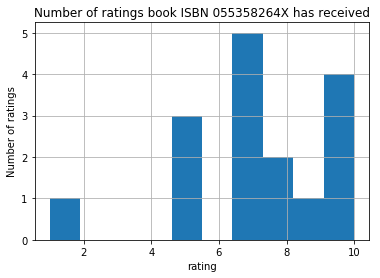

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
rating_new.loc[rating_new['ISBN'] == '0553573616']['bookRating'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings book ISBN 055358264X has received')
plt.show()

It turns out, most of the ratings this book received are around 8, in another word, most of the users in the data rated this book around 8, only user 251140 gives rating 1 to the book. That's why our prediction gives the rating 8.455319.

## 2.2 Item-based Collaborative Filtering

## Exercise 1
Following Section 2.1, please apply item-based collaborative filtering and get the RMSE score. Please don't change the train and test split.

In [29]:
# TODO: please item-based collaborative filtering and get the accuracy as what we did in Section 2.1 ?????????????????
# Hint: for item-based collaborative filtering, we need to change the sim_options

sim_options = {'name': 'cosine',  
               'user_based': False 
               }

algo = KNNWithMeans(sim_options=sim_options)

# fit the model on the taining data and make prediction on the test set
predictions = algo.fit(trainset).test(testset)

# calculate the root mean square errot (RMSE)
accuracy.rmse(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.6275


1.6274596821248608

Question: What's the RMSE score with item-based collaborative filtering?

Answer: About 1.6275

## Exercise 2
Following Section 2.1, please show the worst 10 preidctions by the item-based collaborative filtering, and explain why item-based collaborative filtering gives such prediction.

In [30]:
# TODO: your analyze code here ????????????????????????
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

worst_predictions = df.sort_values(by='err')[-10:]
worst_predictions

uid         iid  rui       est  \
7402   221705  0345444884  2.0  9.715074   
6161   149908  0345416260  1.0  8.820030   
1481   251739  1563890119  2.0  9.897465   
7177    59269  0451161343  1.0  8.941176   
1265    74185  074322535X  1.0  9.010882   
9706   256264  0312291639  1.0  9.019608   
210    219420  3257228007  1.0  9.125000   
10246   43910  0740704818  1.0  9.287368   
7756    76151  067976402X  1.0  9.357519   
10748   76151  0425148297  1.0  9.791942   

                                         details  Iu  Ui       err  
7402   {'actual_k': 15, 'was_impossible': False}  23  25  7.715074  
6161    {'actual_k': 8, 'was_impossible': False}  40  15  7.820030  
1481    {'actual_k': 2, 'was_impossible': False}   6  12  7.897465  
7177    {'actual_k': 1, 'was_impossible': False}  10  16  7.941176  
1265    {'actual_k': 3, 'was_impossible': False}  10  15  8.010882  
9706    {'actual_k': 1, 'was_impossible': False}   1  51  8.019608  
210     {'actual_k': 0, 'was_impossible': False}   4   8  8.125000  
10246  {'actual_k': 10, 'was_impossible': False}  33  12  8.287368  
7756   {'actual_k': 34, 'was_impossible': False}  48  84  8.357519  
10748  {'actual_k': 18, 'was_impossible': False}  48  12  8.791942

TODO: your explanation here: Item-based CF calculates the similarity between items and then predict new items based on the past ratings for similar items.


# 3 Model Based Collaborative Filtering
For model based collaborative filtering, we will mainly focus on matrix factorization based method. We evalaute two models, i.e., singular value decomposition (SVD) and nonnegative matrix factorization (NMF). We will use surprise.prediction_algorithms.matrix_factorization. For details of surprise.prediction_algorithms.matrix_factorization, please refer to: https://surprise.readthedocs.io/en/stable/matrix_factorization.html

## 3.1 Singular Value Decomposition
The objective function of singular value decomposition is very similar to what we have discussed in class. We will use surprise.prediction_algorithms.matrix_factorization.SVD. The important parameters of the SVD function are:

Parameters:	
- n_factors – The number of factors. Default is 100.
- n_epochs – The number of iteration of the SGD procedure. Default is 20.
- biased (bool) – Whether to use baselines (or biases). See note above. Default is True.

For more details, please refer to https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD

In [31]:
from surprise.prediction_algorithms.matrix_factorization import SVD
# specify the options for the algorithm
alg = SVD(n_factors=50, n_epochs=100, biased=True)

# train and predict ratings on the testset
predictions = alg.fit(trainset).test(testset)

# calculate the root mean square errot (RMSE)
accuracy.rmse(predictions)

RMSE: 1.5902


1.5902431271560717

## Exercise 3
The number of factors (we call latent dimension in the lecture) could affect the performance of SVD. Please vary n_factors as 10, 20, 50 and 100, and report the RMSE error below.

In [32]:
## TODO: Your code here ?????????????????
# specify the options for the algorithm
alg = SVD(n_factors=10, n_epochs=100, biased=True)

# train and predict ratings on the testset
predictions = alg.fit(trainset).test(testset)

# calculate the root mean square errot (RMSE)
accuracy.rmse(predictions)

RMSE: 1.7335


1.7335434275148771

In [33]:
# specify the options for the algorithm
alg = SVD(n_factors=20, n_epochs=100, biased=True)

# train and predict ratings on the testset
predictions = alg.fit(trainset).test(testset)

# calculate the root mean square errot (RMSE)
accuracy.rmse(predictions)

RMSE: 1.6715


1.671481631584781

In [34]:
# specify the options for the algorithm
alg = SVD(n_factors=50, n_epochs=100, biased=True)

# train and predict ratings on the testset
predictions = alg.fit(trainset).test(testset)

# calculate the root mean square errot (RMSE)
accuracy.rmse(predictions)

RMSE: 1.5988


1.5988347045008877

In [35]:
# specify the options for the algorithm
alg = SVD(n_factors=100, n_epochs=100, biased=True)

# train and predict ratings on the testset
predictions = alg.fit(trainset).test(testset)

# calculate the root mean square errot (RMSE)
accuracy.rmse(predictions)

RMSE: 1.5657


1.5656678471055594

TODO: Please fill in the RMSE error in the table below

| n_factors     |    10         |    20         |    50         |    100         |
| ------------- |:-------------:|:-------------:|:-------------:|:-------------:|
| RMSE          |  1.7335       |   1.6715      |    1.5988     |  1.5657       |

What pattern do you observe?

Answer: As the n_factors increases, the RMSE error decreases.

## 3.2 Non-negative Matrix Factorization
The non-negative matrix factorization is the same as matrix factorization. The only difference is non-negative matrix factorization has a constriant that the latent representations should be non-negative. This constriant is added becasue the ratings are usually non-negative. Such constraint can make sure that the predicted ratings is also non-negative. We will use the function surprise.prediction_algorithms.matrix_factorization.NMF. The main paramters of NMF are:

Parameters:	
- n_factors – The number of factors. Default is 15.
- n_epochs – The number of iteration of the SGD procedure. Default is 50.
- biased (bool) – Whether to use baselines (or biases). Default is False.

For more details, please refer to https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.NMF

## Exercise 4
Please call surprise.prediction_algorithms.matrix_factorization.NMF with n_factors=50, n_epochs=100, and biased=True. Please calculate the mean square error

In [36]:
# TODO: ???????????????????????
from surprise.prediction_algorithms.matrix_factorization import NMF

In [37]:
# specify the options for the algorithm
alg = NMF(n_factors=50, n_epochs=100, biased=True)

# train and predict ratings on the testset
predictions = alg.fit(trainset).test(testset)

# calculate the root mean square errot (RMSE)
accuracy.rmse(predictions)

RMSE: 1.5980


1.5979746923075102